In [7]:
!pip install TableOne

In [10]:
import warnings

# Suppress deprecation warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [35]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import plotly as py
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import sys
import seaborn as sns

from tableone import TableOne

In [13]:
!pip install pyclustering

from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster import cluster_visualizer
from pyclustering.utils import calculate_distance_matrix

In [14]:
complete_df = pd.read_csv('complete_df.csv')
complete_df_filtered = pd.read_csv('complete_df_filtered.csv')
complete_df_dead = pd.read_csv('complete_df_dead.csv')

In [87]:
# Cluster analysis with filtered population
df = complete_df_filtered.copy()

In [88]:
df['readiness'].value_counts()

readiness
0    332
1    100
Name: count, dtype: int64

In [89]:
# Features of interest
df['dod'] = pd.to_datetime(df['dod'])
df['outtime'] = pd.to_datetime(df['outtime'])

In [90]:
df['initial_vasopressor_needed_within_24hr'] = df['initial_vasopressor_needed_within_24hr'].astype(int)
df['off_vasopressors'] = df['off_vasopressors'].astype(int)
df['initial_ventilation_within_6hr'] = df['initial_ventilation_within_6hr'].astype(int)
df['off_ventilation'] = df['off_ventilation'].astype(int)
df['readiness'] = df['readiness'].astype(int)
df['gender'] = df['gender'].replace({'M': 1, 'F': 0})


In [91]:
features = df[['los',
       'initial_vasopressor_needed_within_24hr',
       'initial_ventilation_within_6hr', 'initial_fio2_above_60_within_6hr',
       'initial_sodium', 'initial_wbc', 'initial_creatinine', 'initial_ph',
       'initial_lactate', 'initial_baseexcess', 'initial_glucose', 'initial_crp',
        'off_vasopressors', 'last_fio2_above_60',
       'off_ventilation', 'last_ph', 'last_lactate', 'last_baseexcess',
       'last_hemoglobin', 'last_creatinine', 'last_sodium', 'last_glucose',
       'last_wbc', 'last_crp', 'readiness']].copy()

In [79]:
features

,los,anchor_age,initial_vasopressor_needed_within_24hr,initial_ventilation_within_6hr,initial_fio2_above_60_within_6hr,initial_sodium,initial_wbc,initial_creatinine,initial_ph,initial_lactate,...,last_ph,last_lactate,last_baseexcess,last_hemoglobin,last_creatinine,last_sodium,last_glucose,last_wbc,last_crp,readiness
0,12.911308,72.0,1,0,0,138.0,3.4,1.0,7.35,11.0,...,7.35,6.2,-7.0,9.7,0.5,146.0,125.0,6.9,NaN,0
1,1.998808,70.0,0,0,0,144.0,9.7,0.7,7.47,1.2,...,NaN,NaN,NaN,NaN,0.8,142.0,114.0,9.1,NaN,0
2,0.835486,63.0,1,1,0,136.0,7.1,1.8,7.47,1.3,...,7.34,NaN,-3.0,NaN,1.8,136.0,57.0,7.2,NaN,0
3,14.146609,55.0,1,1,1,132.0,20.1,3.6,7.39,1.9,...,7.36,0.7,0.0,7.6,1.7,148.0,79.0,12.1,NaN,0
4,1.904410,64.0,0,0,0,134.0,16.0,1.4,7.43,1.4,...,7.39,1.1,2.0,NaN,0.8,140.0,117.0,13.7,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,15.032315,20.0,1,1,1,138.0,30.2,1.1,7.40,4.5,...,7.40,2.2,5.0,10.9,0.5,146.0,98.0,10.0,NaN,0
428,4.781956,55.0,0,0,0,138.0,15.1,1.1,NaN,NaN,...,NaN,NaN,NaN,NaN,0.7,138.0,112.0,6.7,NaN,1
429,5.173843,76.0,0,1,1,139.0,17.5,1.1,7.39,1.8,...,7.39,1.2,4.0,NaN,1.0,139.0,132.0,11.0,95.6,0
430,0.697778,76.0,0,0,0,139.0,9.4,2.1,7.47,2.2,...,7.47,NaN,13.0,NaN,2.1,139.0,116.0,8.2,NaN,0


In [92]:
# Fill missing values with mean of each column
features.fillna(features.mean(), inplace=True)

In [93]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [94]:
tsne = TSNE(n_components=3, random_state=42)  # Setting n_components to 3 for 3D visualization
X_tsne = tsne.fit_transform(features_scaled)

kmeans = KMeans(n_clusters=2)
cluster_labels = kmeans.fit_predict(X_tsne)

df['Cluster'] = cluster_labels
fig = px.scatter_3d(
    x=X_tsne[:, 0], y=X_tsne[:, 1], z=X_tsne[:, 2],  # Coordinates for each point
    color=cluster_labels,  # Assuming 'y' is a vector of labels or a pandas series
    title="3D t-SNE visualization",
    labels={'x': "First t-SNE component", 'y': "Second t-SNE component", 'z': "Third t-SNE component"}
)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



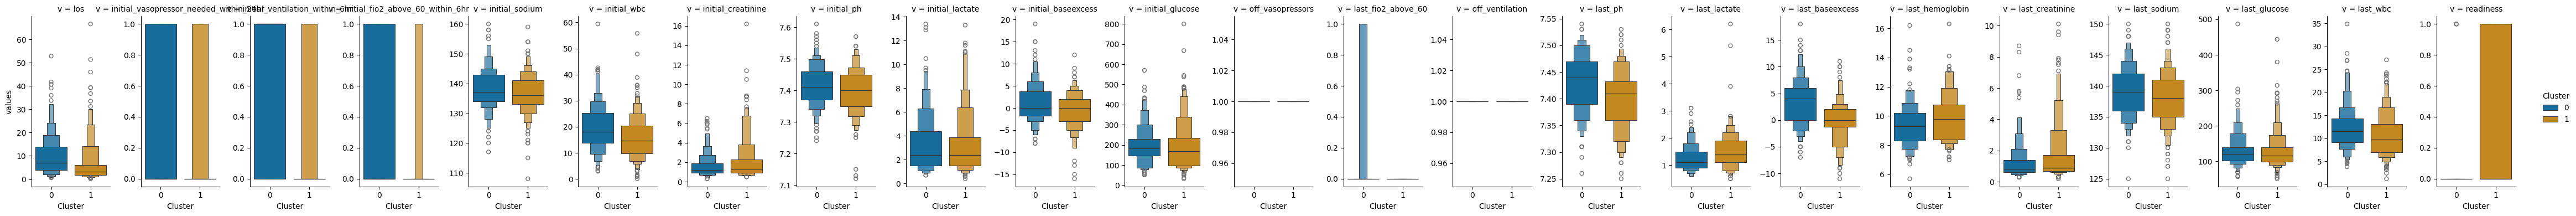

In [134]:
df_long = df.melt(id_vars='Cluster', value_vars=['los',
       'initial_vasopressor_needed_within_24hr',
       'initial_ventilation_within_6hr', 'initial_fio2_above_60_within_6hr',
       'initial_sodium', 'initial_wbc', 'initial_creatinine', 'initial_ph',
       'initial_lactate', 'initial_baseexcess', 'initial_glucose',
        'off_vasopressors', 'last_fio2_above_60',
       'off_ventilation', 'last_ph', 'last_lactate', 'last_baseexcess',
       'last_hemoglobin', 'last_creatinine', 'last_sodium', 'last_glucose',
       'last_wbc', 'readiness'], var_name='v', value_name='values')

sns.catplot(kind='boxen', data=df_long, col='v', y='values', x='Cluster', hue='Cluster',  aspect=0.5, height=4, palette="colorblind", sharey=False)
#sns.factorplot(kind='box', data=df_long, col='variable', y='values', x='Cluster', hue='Cluster', palette="colorblind", sharey=False)

# plt.tight_layout()
plt.Figure(figsize=(25, 15))
plt.show()


In [96]:
# normality test
from scipy.stats import shapiro
from scipy.stats import kstest

categorical = ['gender', 'initial_vasopressor_needed_within_24hr',
       'initial_ventilation_within_6hr', 'initial_fio2_above_60_within_6hr', 'off_vasopressors', 'last_fio2_above_60',
       'off_ventilation', 'readiness']
continuous_list = ['los',
       'initial_sodium', 'initial_wbc', 'initial_creatinine', 'initial_ph',
       'initial_lactate', 'initial_baseexcess', 'initial_glucose', 'initial_crp',
       'last_ph', 'last_lactate', 'last_baseexcess',
       'last_hemoglobin', 'last_creatinine', 'last_sodium', 'last_glucose',
       'last_wbc', 'last_crp']

for s in continuous_list:
  print(s)
  stat, p0 = shapiro(features[s])
  print(s, p0)

los
los 7.471487138920446e-26
initial_sodium
initial_sodium 4.25480175181292e-06
initial_wbc
initial_wbc 5.720944273868156e-10
initial_creatinine
initial_creatinine 1.1313085827025618e-28
initial_ph
initial_ph 9.216508112253052e-11
initial_lactate
initial_lactate 2.152400353463927e-23
initial_baseexcess
initial_baseexcess 2.187599593863449e-15
initial_glucose
initial_glucose 9.041338039652646e-18
initial_crp
initial_crp 1.5074485045555792e-38
last_ph
last_ph 2.9604201756683324e-08
last_lactate
last_lactate 1.1761444752454416e-24
last_baseexcess
last_baseexcess 1.0632450475611677e-10
last_hemoglobin
last_hemoglobin 7.621680554521891e-27
last_creatinine
last_creatinine 2.717591272118008e-29
last_sodium
last_sodium 0.008207026869058609
last_glucose
last_glucose 1.92429648955384e-23
last_wbc
last_wbc 4.609485102641253e-12
last_crp
last_crp 2.3501347391500278e-36


In [101]:
df.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit',
       'intime', 'outtime', 'los', 'anchor_age', 'gender', 'anchor_year',
       'dod', 'sepsis3', 'first_procedure', 'last_procedure', 'procedure_freq',
       'icu_stay_num', 'admission_num', 'in2first_days', 'first2out_days',
       'in2last_days', 'last2out_days', 'first2last_days', 'death',
       'initial_vasopressor_needed_within_24hr',
       'initial_ventilation_within_6hr', 'initial_fio2_above_60_within_6hr',
       'initial_sodium', 'initial_wbc', 'initial_creatinine', 'initial_ph',
       'initial_lactate', 'initial_baseexcess', 'initial_glucose',
       'initial_crp', 'off_vasopressors', 'last_fio2_above_60',
       'off_ventilation', 'last_ph', 'last_lactate', 'last_baseexcess',
       'last_hemoglobin', 'last_creatinine', 'last_sodium', 'last_glucose',
       'last_wbc', 'last_crp', 'readiness', 'Cluster'],
      dtype='object')

In [112]:
# columns = [col for col in features.columns if (col != 'cluster_labels' and col != 'subject_id' and col != 'stay_id')]

columns = [ 'los', 'anchor_age', 'gender',  'procedure_freq',
       'icu_stay_num', 'admission_num', 'in2first_days', 'first2out_days',
       'in2last_days', 'last2out_days', 'first2last_days', 'death',
       'initial_vasopressor_needed_within_24hr',
       'initial_ventilation_within_6hr', 'initial_fio2_above_60_within_6hr',
       'initial_sodium', 'initial_wbc', 'initial_creatinine', 'initial_ph',
       'initial_lactate', 'initial_baseexcess', 'initial_glucose',
       'initial_crp', 'off_vasopressors', 'last_fio2_above_60',
       'off_ventilation', 'last_ph', 'last_lactate', 'last_baseexcess',
       'last_hemoglobin', 'last_creatinine', 'last_sodium', 'last_glucose',
       'last_wbc', 'last_crp', 'readiness']
columns2 = ['los', 'gender',
       'initial_vasopressor_needed_within_24hr',
       'initial_ventilation_within_6hr', 'initial_fio2_above_60_within_6hr',
       'initial_sodium', 'initial_wbc', 'initial_creatinine', 'initial_ph',
       'initial_lactate', 'initial_baseexcess', 'initial_glucose', 'initial_crp',
        'off_vasopressors', 'last_fio2_above_60',
       'off_ventilation', 'last_ph', 'last_lactate', 'last_baseexcess',
       'last_hemoglobin', 'last_creatinine', 'last_sodium', 'last_glucose',
       'last_wbc', 'last_crp', 'readiness']

categorical = ['gender', 'initial_vasopressor_needed_within_24hr',
       'initial_ventilation_within_6hr', 'initial_fio2_above_60_within_6hr', 'off_vasopressors', 'last_fio2_above_60',
       'off_ventilation', 'readiness']


groupby = ['Cluster']
nonnormal = [col for col in columns if (col != 'last_sodium')]
mytable = TableOne(df, columns=columns2, categorical=categorical, groupby=groupby, nonnormal=nonnormal, pval=True)

In [113]:
print(mytable.tabulate(tablefmt = 'fancy_grid'))

╒════════════════════════════════════════════════════════╤═════╤═══════════╤═════════════════════╤═════════════════════╤═════════════════════╤═══════════╕
│                                                        │     │ Missing   │ Overall             │ 0                   │ 1                   │ P-Value   │
╞════════════════════════════════════════════════════════╪═════╪═══════════╪═════════════════════╪═════════════════════╪═════════════════════╪═══════════╡
│ n                                                      │     │           │ 432                 │ 190                 │ 242                 │           │
├────────────────────────────────────────────────────────┼─────┼───────────┼─────────────────────┼─────────────────────┼─────────────────────┼───────────┤
│ los, median [Q1,Q3]                                    │     │ 0         │ 4.5 [2.1,10.5]      │ 7.0 [4.0,14.0]      │ 3.2 [1.8,6.0]       │ <0.001    │
├────────────────────────────────────────────────────────┼─────┼──────

In [136]:
# Table 1 recalculation
columns = [ 'los', 'anchor_age', 'gender',  'procedure_freq',
       'icu_stay_num', 'admission_num', 'in2first_days', 'first2out_days',
       'in2last_days', 'last2out_days', 'first2last_days', 'death',
       'initial_vasopressor_needed_within_24hr',
       'initial_ventilation_within_6hr', 'initial_fio2_above_60_within_6hr',
       'initial_sodium', 'initial_wbc', 'initial_creatinine', 'initial_ph',
       'initial_lactate', 'initial_baseexcess', 'initial_glucose',
       'initial_crp', 'off_vasopressors', 'last_fio2_above_60',
       'off_ventilation', 'last_ph', 'last_lactate', 'last_baseexcess',
       'last_hemoglobin', 'last_creatinine', 'last_sodium', 'last_glucose',
       'last_wbc', 'last_crp', 'readiness']

categorical = ['gender', 'initial_vasopressor_needed_within_24hr',
       'initial_ventilation_within_6hr', 'initial_fio2_above_60_within_6hr', 'off_vasopressors', 'last_fio2_above_60',
       'off_ventilation', 'readiness']

groupby = ['Cluster']
nonnormal = [col for col in columns if (col != 'last_sodium')]
mytable = TableOne(df, columns=columns, categorical=categorical, groupby=groupby, nonnormal=nonnormal)
print(mytable.tabulate(tablefmt = 'fancy_grid'))

╒════════════════════════════════════════════════════════╤═════╤═══════════╤═════════════════════╤═════════════════════╤═════════════════════╕
│                                                        │     │ Missing   │ Overall             │ 0                   │ 1                   │
╞════════════════════════════════════════════════════════╪═════╪═══════════╪═════════════════════╪═════════════════════╪═════════════════════╡
│ n                                                      │     │           │ 432                 │ 190                 │ 242                 │
├────────────────────────────────────────────────────────┼─────┼───────────┼─────────────────────┼─────────────────────┼─────────────────────┤
│ los, median [Q1,Q3]                                    │     │ 0         │ 4.5 [2.1,10.5]      │ 7.0 [4.0,14.0]      │ 3.2 [1.8,6.0]       │
├────────────────────────────────────────────────────────┼─────┼───────────┼─────────────────────┼─────────────────────┼─────────────────────┤

In [138]:
cluster_0_counts = df[df['Cluster'] == 0].groupby('subject_id')['stay_id'].nunique()
cluster_1_counts = df[df['Cluster'] == 1].groupby('subject_id')['stay_id'].nunique()

multiple_stays_cluster_0 = cluster_0_counts[cluster_0_counts > 1]
multiple_stays_cluster_1 = cluster_1_counts[cluster_1_counts > 1]

distinct_subjects_multiple_stays_cluster_0 = multiple_stays_cluster_0.count()
distinct_subjects_multiple_stays_cluster_1 = multiple_stays_cluster_1.count()

total_distinct_subjects_cluster_0 = df[df['Cluster'] == 0]['subject_id'].nunique()
total_distinct_subjects_cluster_1 = df[df['Cluster'] == 1]['subject_id'].nunique()

percentage_cluster_0 = (distinct_subjects_multiple_stays_cluster_0 / total_distinct_subjects_cluster_0) * 100
percentage_cluster_1 = (distinct_subjects_multiple_stays_cluster_1 / total_distinct_subjects_cluster_1) * 100

print(f"Cluster 0: {distinct_subjects_multiple_stays_cluster_0} subjects with multiple stays, which is {percentage_cluster_0:.2f}% of all subjects in the cluster.")
print(f"Cluster 1: {distinct_subjects_multiple_stays_cluster_1} subjects with multiple stays, which is {percentage_cluster_1:.2f}% of all subjects in the cluster.")

Cluster 0: 3 subjects with multiple stays, which is 1.61% of all subjects in the cluster.
Cluster 1: 10 subjects with multiple stays, which is 4.33% of all subjects in the cluster.


In [139]:
subject_stay_counts = df.groupby(['subject_id', 'Cluster'])['stay_id'].nunique().reset_index()

multiple_stays = subject_stay_counts[subject_stay_counts['stay_id'] > 1]

counts_per_cluster = multiple_stays.groupby('Cluster')['subject_id'].nunique()

total_subjects_per_cluster = df.groupby('Cluster')['subject_id'].nunique()
percentage_per_cluster = (counts_per_cluster / total_subjects_per_cluster) * 100

overall_count = multiple_stays['subject_id'].nunique()
total_subjects = df['subject_id'].nunique()
overall_percentage = (overall_count / total_subjects) * 100

print("Counts per cluster:")
print(counts_per_cluster)
print("\nPercentages per cluster:")
print(percentage_per_cluster)
print(f"\nOverall count of subjects with multiple stays: {overall_count}")
print(f"Overall percentage of subjects with multiple stays: {overall_percentage:.2f}%")

Counts per cluster:
Cluster
0     3
1    10
Name: subject_id, dtype: int64

Percentages per cluster:
Cluster
0    1.612903
1    4.329004
Name: subject_id, dtype: float64

Overall count of subjects with multiple stays: 13
Overall percentage of subjects with multiple stays: 3.17%


In [143]:
# Group by 'subject_id' and find the maximum 'procedure_freq' for each 'subject_id'
max_procedure_freq = df.groupby('subject_id')['procedure_freq'].max().reset_index()

# Calculate the overall median, Q1, and Q3 for the maximum 'procedure_freq'
overall_stats = {
    'Median': max_procedure_freq['procedure_freq'].median(),
    'Q1': max_procedure_freq['procedure_freq'].quantile(0.25),
    'Q3': max_procedure_freq['procedure_freq'].quantile(0.75)
}

# Now, repeat the process for each cluster
cluster_0_max_freq = df[df['Cluster'] == 0].groupby('subject_id')['procedure_freq'].max()
cluster_1_max_freq = df[df['Cluster'] == 1].groupby('subject_id')['procedure_freq'].max()

cluster_0_stats = {
    'Median': cluster_0_max_freq.median(),
    'Q1': cluster_0_max_freq.quantile(0.25),
    'Q3': cluster_0_max_freq.quantile(0.75)
}

cluster_1_stats = {
    'Median': cluster_1_max_freq.median(),
    'Q1': cluster_1_max_freq.quantile(0.25),
    'Q3': cluster_1_max_freq.quantile(0.75)
}

# Output the results
print(f"Overall Stats: Median = {overall_stats['Median']}, Q1 = {overall_stats['Q1']}, Q3 = {overall_stats['Q3']}")
print(f"Cluster 0 Stats: Median = {cluster_0_stats['Median']}, Q1 = {cluster_0_stats['Q1']}, Q3 = {cluster_0_stats['Q3']}")
print(f"Cluster 1 Stats: Median = {cluster_1_stats['Median']}, Q1 = {cluster_1_stats['Q1']}, Q3 = {cluster_1_stats['Q3']}")

Overall Stats: Median = 1.0, Q1 = 1.0, Q3 = 1.0
Cluster 0 Stats: Median = 1.0, Q1 = 1.0, Q3 = 1.0
Cluster 1 Stats: Median = 1.0, Q1 = 1.0, Q3 = 1.0


In [141]:
# Non-survivors
# df = df.complete_df_dead.copy()
columns = [ 'los', 'anchor_age', 'gender',  'procedure_freq',
       'icu_stay_num', 'admission_num', 'in2first_days', 'first2out_days',
       'in2last_days', 'last2out_days', 'first2last_days', 'death',
       'initial_vasopressor_needed_within_24hr',
       'initial_ventilation_within_6hr', 'initial_fio2_above_60_within_6hr',
       'initial_sodium', 'initial_wbc', 'initial_creatinine', 'initial_ph',
       'initial_lactate', 'initial_baseexcess', 'initial_glucose',
       'initial_crp', 'off_vasopressors', 'last_fio2_above_60',
       'off_ventilation', 'last_ph', 'last_lactate', 'last_baseexcess',
       'last_hemoglobin', 'last_creatinine', 'last_sodium', 'last_glucose',
       'last_wbc', 'last_crp', 'readiness']

categorical = ['gender', 'initial_vasopressor_needed_within_24hr',
       'initial_ventilation_within_6hr', 'initial_fio2_above_60_within_6hr', 'off_vasopressors', 'last_fio2_above_60',
       'off_ventilation', 'readiness']

nonnormal = [col for col in columns if (col != 'last_sodium')]
mytable = TableOne(complete_df_dead, columns=columns, categorical=categorical, nonnormal=nonnormal)
print(mytable.tabulate(tablefmt = 'fancy_grid'))

╒════════════════════════════════════════════════════════╤═════╤═══════════╤═════════════════════╕
│                                                        │     │ Missing   │ Overall             │
╞════════════════════════════════════════════════════════╪═════╪═══════════╪═════════════════════╡
│ n                                                      │     │           │ 31                  │
├────────────────────────────────────────────────────────┼─────┼───────────┼─────────────────────┤
│ los, median [Q1,Q3]                                    │     │ 0         │ 7.9 [4.2,18.0]      │
├────────────────────────────────────────────────────────┼─────┼───────────┼─────────────────────┤
│ anchor_age, median [Q1,Q3]                             │     │ 0         │ 69.0 [59.0,78.5]    │
├────────────────────────────────────────────────────────┼─────┼───────────┼─────────────────────┤
│ gender, median [Q1,Q3]                                 │ 0.0 │ 0         │ 10 (32.3)           │
├─────────

/usr/local/lib/python3.10/dist-packages/tableone/tableone.py:918: RuntimeWarning:

'initial_crp' has all non-numeric values. Consider including it in the list of categorical variables.

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning:

Mean of empty slice

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning:

Degrees of freedom <= 0 for slice.

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning:

All-NaN slice encountered

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning:

All-NaN slice encountered

/usr/local/lib/python3.10/dist-packages/tableone/tableone.py:859: RuntimeWarning:

All-NaN slice encountered

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning:

All-NaN slice encountered



In [ ]:
  ## Additional Models
## random forest
df_f = df.copy()
df_f['initial_vasopressor_needed_within_24hr'] = df['initial_vasopressor_needed_within_24hr'].astype(int)
df_f['off_vasopressors'] = df['off_vasopressors'].astype(int)
df_f['initial_ventilation_within_6hr'] = df['initial_ventilation_within_6hr'].astype(int)
df_f['off_ventilation'] = df['off_ventilation'].astype(int)
df_f['readiness'] = df['readiness'].astype(int)
df_f = df_f[['subject_id','stay_id', 'los',
       'initial_vasopressor_needed_within_24hr',
       'initial_ventilation_within_6hr', 'initial_fio2_above_60_within_6hr',
       'initial_sodium', 'initial_wbc', 'initial_creatinine', 'initial_ph',
       'initial_lactate', 'initial_baseexcess', 'initial_glucose',
       'initial_crp', 'off_vasopressors', 'last_fio2_above_60',
       'off_ventilation', 'last_ph', 'last_lactate', 'last_baseexcess',
       'last_hemoglobin', 'last_creatinine', 'last_sodium', 'last_glucose',
       'last_wbc', 'last_crp', 'readiness']].copy()


df_f.fillna(df_f.mean(), inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:

from sklearn.metrics import auc, roc_curve
X = df_f.drop(['los', 'subject_id', 'stay_id','initial_crp','last_crp'], axis=1)  # Exclude identifiers and target
y = df_f['los']

X.fillna(X.mean(), inplace=True)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Create and fit the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predicting the Test set results
y_pred = model.predict(X_test)
#y_pred_prob = model.predict_proba(X_test)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')

#fpr_brf, tpr_brf, thresholds = roc_curve(y_test, y_pred, pos_label=1)
#roc_auc_brf = auc(fpr_brf, tpr_brf)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Mean Squared Error: 80.72060145721237


In [ ]:
y_test.describe()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



count    232.000000
mean       8.615413
std        9.584953
min        0.184641
25%        2.402535
50%        5.010700
75%       11.814433
max       66.584236
Name: los, dtype: float64

In [ ]:
y_pred.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



(232,)

In [ ]:
roc_auc = roc_auc_score(y_test, y_pred)
roc_auc

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



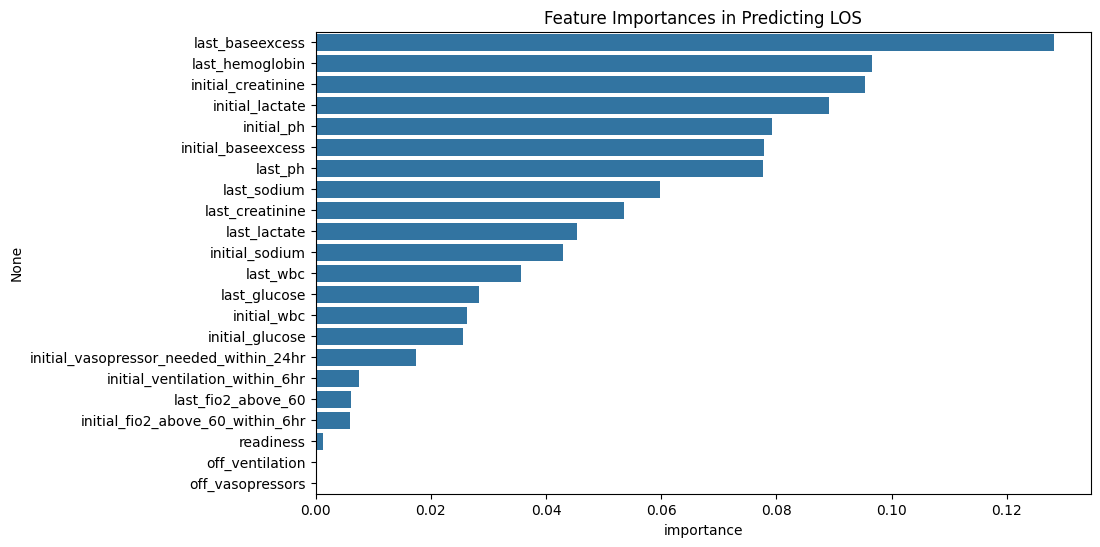

In [ ]:
feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y=feature_importances.index, data=feature_importances)
plt.title('Feature Importances in Predicting LOS')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



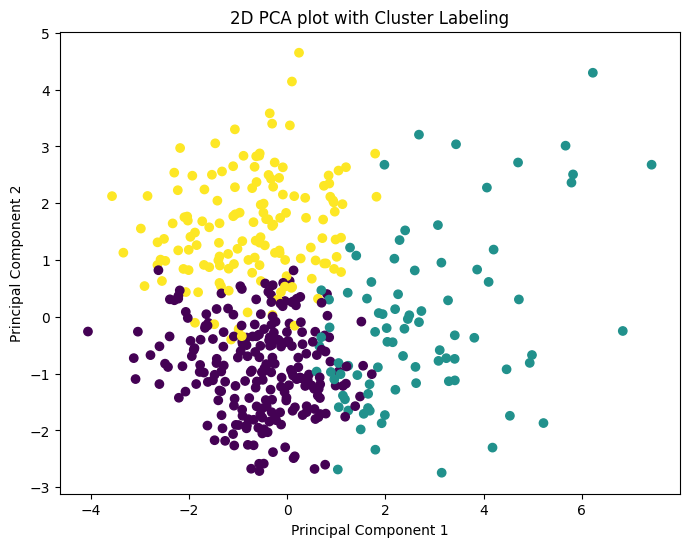

In [ ]:



# Other approaches

# Run PCA for dimensionality reduction for visualization (if desired)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_scaled)
principal_df = pd.DataFrame(data=principal_components, columns=['principal_component_1', 'principal_component_2'])

kmeans = KMeans(n_clusters=3)  # Choose the number of clusters
cluster_labels = kmeans.fit_predict(features_scaled)

df['Cluster'] = cluster_labels
principal_df['Cluster'] = cluster_labels

plt.figure(figsize=(8, 6))
plt.scatter(principal_df['principal_component_1'], principal_df['principal_component_2'], c=principal_df['Cluster'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA plot with Cluster Labeling')
plt.show()

In [ ]:
fig_kmeans = px.box(df, x='Cluster', y='initial_creatinine',
                    title='Initial Creatinine Levels Distribution by KMeans Clusters',
                    labels={'Cluster': 'KMeans Cluster'})
fig_kmeans.show()

In [ ]:
import plotly.express as px

# Assuming 'principal_df' is your DataFrame containing PCA results and 'Cluster' labels
fig_pca = px.scatter(principal_df, x='principal_component_1', y='principal_component_2',
                     color='Cluster',
                     title='PCA Results with Cluster Labels',
                     labels={'principal_component_1': 'Principal Component 1', 'principal_component_2': 'Principal Component 2'})
fig_pca.show()

In [ ]:
distance_matrix = calculate_distance_matrix(features_scaled)

# Choose initial medoids. For this example, we'll pick random indexes as medoids
initial_medoids = [1, 10, 20]

# Create instance of K-Medoids algorithm
kmedoids_instance = kmedoids(distance_matrix, initial_medoids, data_type='distance_matrix')

# Run cluster analysis and obtain results
kmedoids_instance.process()
clusters = kmedoids_instance.get_clusters()
medoids = kmedoids_instance.get_medoids()

# You can now assign the cluster labels to your original dataframe
cluster_labels = [0] * len(df)
for cluster_id, cluster in enumerate(clusters):
    for index in cluster:
        cluster_labels[index] = cluster_id

df['KMedoids_Cluster'] = cluster_labels

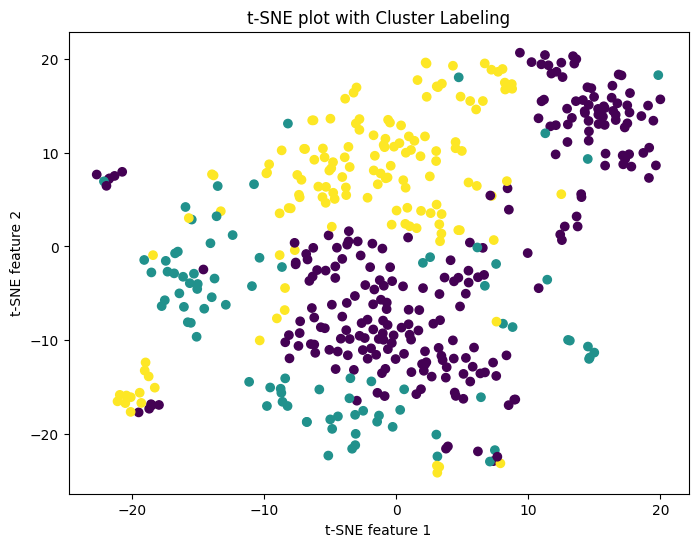

In [ ]:
from sklearn.manifold import TSNE

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(features_scaled)

# Create a DataFrame to plot
tsne_df = pd.DataFrame(data=tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_df['Cluster'] = cluster_labels  # Use the cluster labels from KMeans or KMedoids

# Plot the t-SNE results with cluster labels
plt.figure(figsize=(8, 6))
plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], c=tsne_df['Cluster'])
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.title('t-SNE plot with Cluster Labeling')
plt.show()

In [ ]:
from sklearn.manifold import TSNE
import plotly.express as px

# Let's assume 'features_scaled' is your scaled dataset ready for t-SNE
# Perform t-SNE dimensionality reduction to 3 components
tsne_3d = TSNE(n_components=3, perplexity=30, n_iter=3000, random_state=42)
tsne_3d_results = tsne_3d.fit_transform(features_scaled)

# Create a DataFrame containing the t-SNE results and cluster labels
tsne_3d_df = pd.DataFrame(data=tsne_3d_results, columns=['TSNE1', 'TSNE2', 'TSNE3'])
tsne_3d_df['Cluster'] = cluster_labels

# Visualize with Plotly
fig_3d = px.scatter_3d(tsne_3d_df, x='TSNE1', y='TSNE2', z='TSNE3',
                        color='Cluster', labels={'Cluster': 'Cluster Label'},
                        title='3D t-SNE Results with Cluster Labels')
fig_3d.update_traces(marker=dict(size=3))
fig_3d.show()